# Solar Cell Circuit Demo
This notebook shows how to build and run a silicon wafer solar cell circuit model.

In [1]:
from PV_Circuit_Model.cell import *
from PV_Circuit_Model.module import *
from PV_Circuit_Model.cell_analysis import *

## Create a quick solar cell

In [2]:
cell = quick_solar_cell()

## Visualize wafer geometry

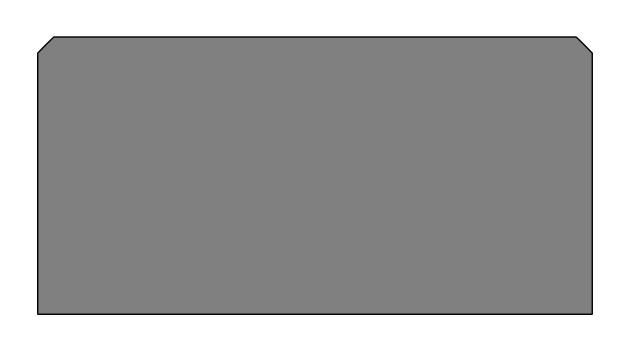

In [3]:
cell.draw_cells()
cell.show()

## Circuit model representation

100%|██████████| 7/7 [00:00<00:00, 422.85it/s]


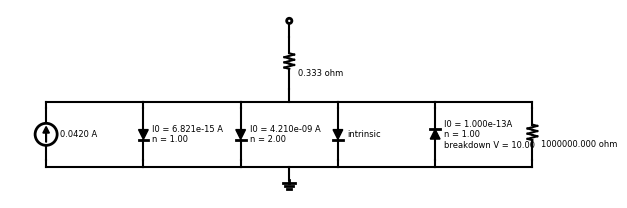

In [4]:
cell.draw(display_value=True, title="Cell Model")

## Plot IV curve

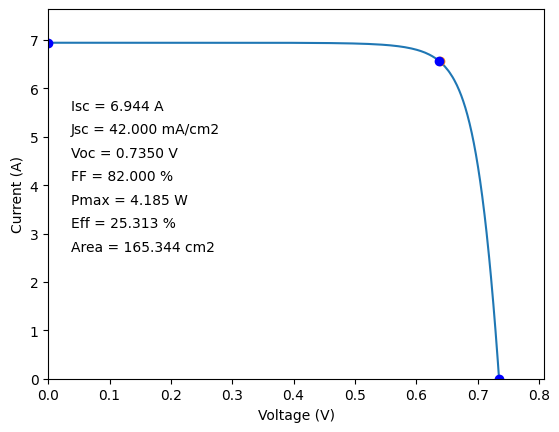

In [5]:
cell.plot(title="Cell I-V Curve")
cell.show()

# PV Module Demo
This notebook shows how to build and run a circuit model of a PV module.

In [6]:
from PV_Circuit_Model.cell import *
from PV_Circuit_Model.module import *
from PV_Circuit_Model.cell_analysis import *

## Create a butterfly PV module

In [7]:
module = quick_butterfly_module()

Tweaking module cell parameters...:  30%|███       | 6/20 [00:02<00:05,  2.61it/s]


## Visualize module cell layout

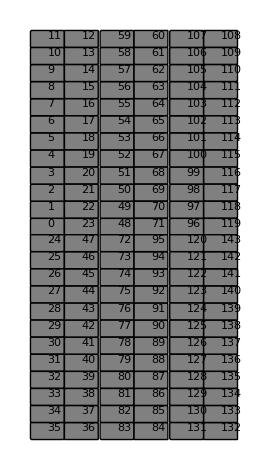

In [8]:
_ = module.draw_cells(show_names=True,colour_what=None)

## Circuit model representation

100%|██████████| 1017/1017 [00:01<00:00, 716.76it/s]


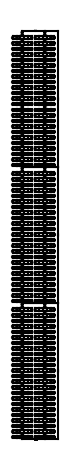

In [9]:
module.draw(title="Module model")

## Plot IV curve

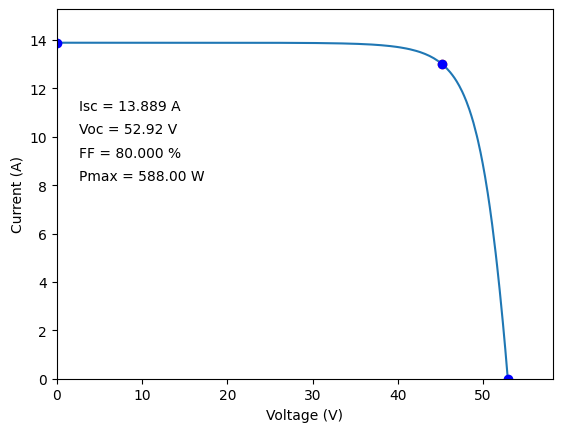

In [10]:
module.plot(title="Module I-V Curve")
module.show()

## Introduce some cells JL and J01 inhomogenity

In [11]:
for cell in module.cells:
    cell.set_JL(cell.JL() * min(1.0,np.random.normal(loc=1.0, scale=0.01)))
    cell.set_J01(cell.J01() * max(1.0,np.random.normal(loc=1.0, scale=0.2)))
module.build_IV()

## Replot I-V Curve with the inhomogenity

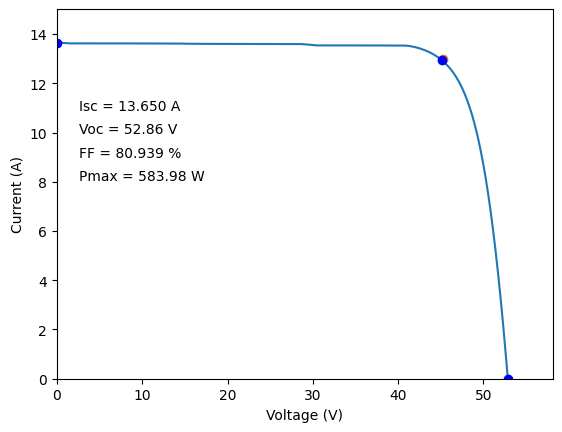

In [12]:
module.plot(title="Module I-V Curve with inhomogenity")
module.show()

## Simulate cell internal voltages under electroluminescence (EL) conditions 
No illumination, drive module at 10A forward bias

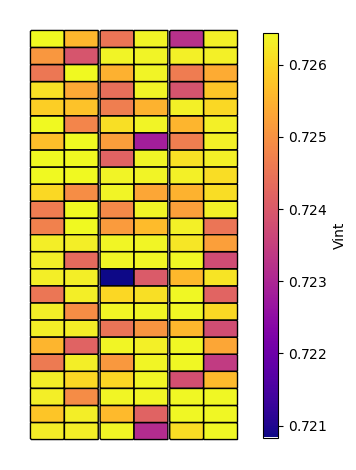

In [13]:
module.set_Suns(0.0) 
module.set_operating_point(I=10)
_ = module.draw_cells(title="Cells Vint with inhomogenity",colour_bar=True)

## Introduce high series resistance to cell #1 inside the module 

In [14]:
module.cells[0].set_specific_Rs(40.0)

## Replot I-V Curve with the cell with high series resistance

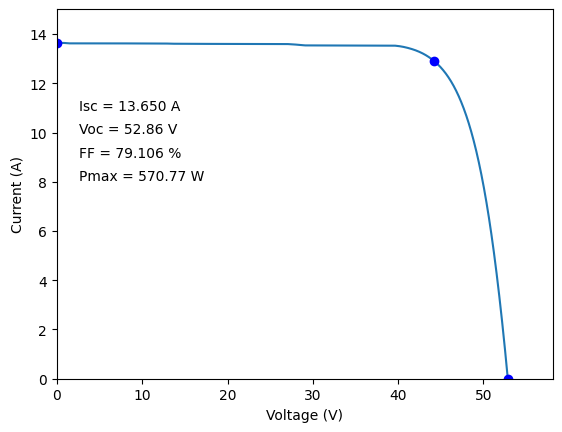

In [15]:
module.set_Suns(1.0) 
module.plot(title="Module I-V Curve with additional high Rs cell")
module.show()

## Resimulate cell internal voltages under electroluminescence (EL) conditions 
No illumination, drive module at 10A forward bias

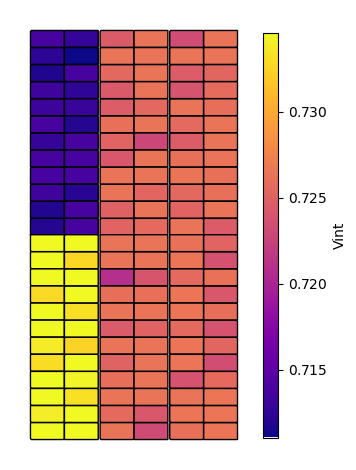

In [16]:
module.set_Suns(0.0) 
module.set_operating_point(I=10)
_ = module.draw_cells(title="Cell Vint with additional high Rs cell",colour_bar=True)

# Tandem Cell Demo
This notebook shows how to build and run a perovskite-silicon tandem cell circuit model.

In [17]:
from PV_Circuit_Model.cell import *
from PV_Circuit_Model.cell_analysis import *
from PV_Circuit_Model.multi_junction_cell import *

## Create a bottom cell

In [18]:
bottom_cell = quick_solar_cell()
bottom_cell.set_JL(19.0e-3)

## Create a top cell

In [19]:
Jsc_top_cell = 20.5e-3
Voc_top_cell = 1.18
J01_PC = 5e-24

J01, J02 = estimate_cell_J01_J02(Jsc=Jsc_top_cell,Voc=Voc_top_cell,Si_intrinsic_limit=False)
top_cell = make_solar_cell(Jsc_top_cell, J01, J02, 
                        area=bottom_cell.area, 
                        Si_intrinsic_limit=False,J01_photon_coupling=J01_PC)

## Put them together to make a tandem cell

In [20]:
tandem_cell = MultiJunctionCell([bottom_cell,top_cell])

## Circuit model representation

100%|██████████| 14/14 [00:00<00:00, 565.61it/s]


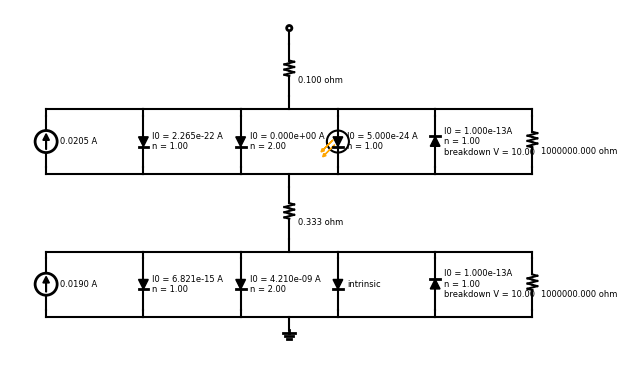

In [21]:
tandem_cell.draw(display_value=True,title="Tandem Cell Model")

## Plot IV curve

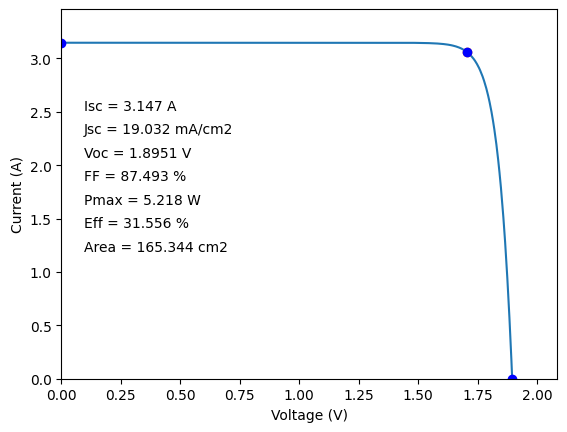

In [22]:
tandem_cell.plot(title="Tandem Cell I-V Curve")
tandem_cell.show()

# Tandem Cell Measurement Fitting Demo

This example fits a tandem cell model to the tandem measurements of a large area
perovskite-silicon solar cell.  Each measurement is stored in a json file 
(see json_directory) in the format that PV_Circuit_Model Measurement class can read in.
There are three kinds of measurements:
Light I-V at different top, bottom cell JLs (i.e. spectrometric IV)
"Dark I-V" where one subcell is in the "dark" and the other cell is illuminated
Suns-Voc, namely with blue, red (IR) and white light spectra

Calibrating:   3%|▎         | 9/352 [00:00<00:33, 10.12it/s]

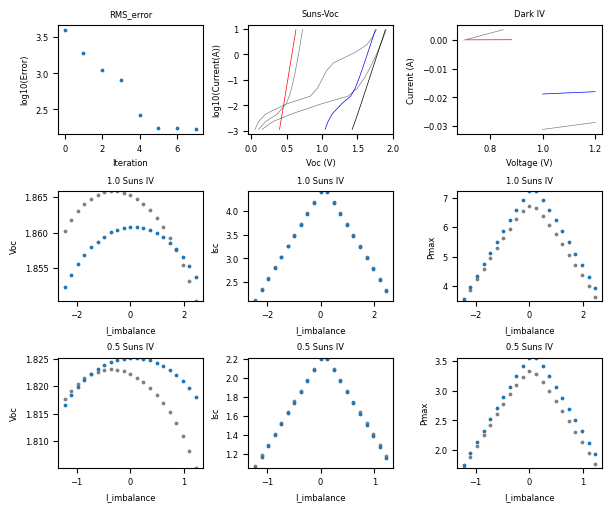

Calibrating:  20%|██        | 72/352 [00:07<00:26, 10.57it/s]

In [ ]:

from PV_Circuit_Model.data_fitting_tandem_cell import *

json_directory = r"tandem measurement json files/"
sample_info = {"area":244.26,"bottom_cell_thickness":180e-4}

measurements = get_measurements(json_directory)
ref_cell_model, interactive_fit_dashboard = analyze_solar_cell_measurements(measurements,sample_info=sample_info,is_tandem=True)

# Draw best fit circuit representation
Draw the resultant tandem cell model with the best fit parameters

In [ ]:
ref_cell_model.draw(title="Tandem Cell with Best Fit Parameters",display_value=True)

# Topcon Cell Measurement Fitting Demo

This example fits a single junction silicon cell model to the measurements of a large area
Topcon silicon wafer solar cell.  Each measurement is stored in a json file 
(see json_directory) in the format that PV_Circuit_Model Measurement class can read in.
There are three kinds of measurements:
Light I-V at 1 Sun, 0.5 Sun
Dark I-V, Suns-Voc

In [ ]:

from PV_Circuit_Model.data_fitting_tandem_cell import *

json_directory = r"topcon measurement json files/"
sample_info = {"area":165.34,"bottom_cell_thickness":180e-4}

measurements = get_measurements(json_directory)

ref_cell_model, interactive_fit_dashboard = analyze_solar_cell_measurements(measurements,sample_info=sample_info,is_tandem=False,num_of_rounds=15)

# Draw best fit circuit representation
Draw the resultant cell model with the best fit parameters

In [ ]:
ref_cell_model.draw(title="Tandem Cell with Best Fit Parameters",display_value=True)




